In [1]:
from summary_models import *
from cl_models import RNVP, NSF_CL
from ar_models import NSF_AR, MAF
from classifier import ResNet
from plot import pairplot
from dataloader import *
from torch.utils.data import DataLoader
from NLE import NLEHandler
from NPE import NPEHandler
from NRE import NREHandler
from Trainer import SNHandler, Trainer
from analysis import Analysis
#my_module_path = os.path.join("../", '21cm-wrappe}r')
#sys.path.append(my_module_path)
#from Leaf import * 
#from sbi import analysis
from ray import tune
from torchsummary import summary


%matplotlib inline

device = 'cuda:0'
import multiprocessing as mp
mp.set_start_method('fork', force=True)
#torch.set_num_interop_threads(4) # Inter-op parallelism
#torch.set_num_threads(6) # Intra-op parallelism


/home/allomere/Documents/projects/master/21cm-sbi/Trainer.py:446: SyntaxWarning: invalid escape sequence '\d'
  """class RecNetHandler(SNHandler):
/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/allomere/Documents/projects/master/21cm-sbi/analysis.py:32: SyntaxWarning: invalid escape sequence '\O'
  """Class to analyse a neural posterior (NPE) estimator on several metrics.


In [ ]:
dd

In [2]:
# Define the configuration for the summary_net_lc_smol
init_layers = {
    "layer_size1": 1,
    "channel1": 48,
    "kernel_size1_xy": 3,
    "kernel_size1_z": 47,
    
    "layer_size2": 1,
    "channel2": 48,
    "kernel_size2": 3,
    
    "layer_size3": 1,
    "channel3": 64,
    "kernel_size3": 3,
    
    "layer_size4": 1,
    "channel4": 96,
    "kernel_size4": 3,
}

# Initialize the summary_net_lc_smol with the given configuration
summary_net = Summary_net_lc_smol(init_layers=init_layers).to(device)

# Print the summary of the model to verify the configuration
summary(summary_net, input_size=[(1, 28, 28, 470),(1,2)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 48, 32, 32, 518]          20,352
       BatchNorm3d-2      [-1, 48, 32, 32, 518]              96
              GELU-3      [-1, 48, 32, 32, 518]               0
            Conv3d-4      [-1, 48, 32, 32, 518]           2,352
         MaxPool3d-5      [-1, 48, 16, 16, 259]               0
            Conv3d-6      [-1, 48, 16, 16, 259]          62,256
       BatchNorm3d-7      [-1, 48, 16, 16, 259]              96
              GELU-8      [-1, 48, 16, 16, 259]               0
            Conv3d-9      [-1, 48, 16, 16, 259]           2,352
        MaxPool3d-10        [-1, 48, 8, 8, 129]               0
           Conv3d-11        [-1, 64, 8, 8, 129]          83,008
      BatchNorm3d-12        [-1, 64, 8, 8, 129]             128
             GELU-13        [-1, 64, 8, 8, 129]               0
           Conv3d-14        [-1, 64, 8,

In [6]:
from utility import convert_pt_to_2dps
convert_pt_to_2dps("/home/allomere/Documents/projects/master/data/datax5/", "batch_", debug=True, summary_statistics_parameters={"bins": 5, "BOX_LEN": 200, "HII_DIM":28, "z-eval": np.linspace(6,18,4)})

['batch_8323.pt', 'batch_11225.pt', 'batch_4691.pt', 'batch_8228.pt', 'batch_6055.pt', 'batch_5288.pt', 'batch_10936.pt', 'batch_1886.pt', 'batch_491.pt', 'batch_5710.pt', 'batch_363.pt', 'batch_3763.pt', 'batch_400.pt', 'batch_1986.pt', 'batch_10649.pt', 'batch_5293.pt', 'batch_9429.pt', 'batch_680.pt', 'batch_7020.pt', 'batch_6727.pt', 'batch_6240.pt', 'batch_3967.pt', 'batch_4023.pt', 'batch_209.pt', 'batch_10909.pt', 'batch_8557.pt', 'batch_8986.pt', 'batch_10824.pt', 'batch_4567.pt', 'batch_4527.pt', 'batch_500.pt', 'batch_3856.pt', 'batch_576.pt', 'batch_5388.pt', 'batch_8412.pt', 'batch_7552.pt', 'batch_974.pt', 'batch_1174.pt', 'batch_9046.pt', 'batch_5449.pt', 'batch_9806.pt', 'batch_10521.pt', 'batch_3831.pt', 'batch_6575.pt', 'batch_1399.pt', 'batch_2520.pt', 'batch_10777.pt', 'batch_5813.pt', 'batch_5822.pt', 'batch_79.pt', 'batch_7079.pt', 'batch_51.pt', 'batch_5436.pt', 'batch_3063.pt', 'batch_4262.pt', 'batch_5200.pt', 'batch_3492.pt', 'batch_6783.pt', 'batch_809.pt', 'b

In [7]:
# hyperparams
data_path = "/home/allomere/Documents/projects/master/data/datax5/"
batch_size = 16
epochs = 20
train_test_data_ration = 0.8

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 5e-3,
}


loss = torch.nn.MSELoss
loss_params = {}

norm_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)


# transform trainingsdata
# perhaps add check if file is there: continue + override option in the future
#convert_to_torch(path = data_path, prefix="run", redshift_cutoff=600, debug=False, statistics=True)
#noise_model = mock_noise("/home/allomere/Documents/projects/master/21cm_pie")
# load data
train_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = True, expand_dim = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0.5, psvar=False)
test_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = False, expand_dim = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0, psvar=False)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True,
                              num_workers = 0, pin_memory = True, prefetch_factor=None)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True,
                             num_workers = 0, pin_memory = True, prefetch_factor=None)

# init model
model_sn = SNHandler(encoder=Summary_net_lc_super_smol, device=device,)
#model_rec = RecNetHandler(Model = global_temp_smol_inv_super_smol, summary_net = model_sn.Model, device=device)
#summary(model_sn.Model, [(10,9), (2,)])
# traind
'''loss_tmp= model_sn.training(
    training_data = train_dataloader,
    test_data = test_dataloader,
    epochs=epochs,
    config = {
        "optimizer": optimizer,
        "optimizer_kwargs": optimizer_params,
    },
    )
model_sn.plot("training_sn_test")
model_sn.save("sumnet_1d.pt")'''

INFO: Succesfully initialized SNHandler


'loss_tmp= model_sn.training(\n    training_data = train_dataloader,\n    test_data = test_dataloader,\n    epochs=epochs,\n    config = {\n        "optimizer": optimizer,\n        "optimizer_kwargs": optimizer_params,\n    },\n    )\nmodel_sn.plot("training_sn_test")\nmodel_sn.save("sumnet_1d.pt")'

In [ ]:

labels = [1,1]
user_params = p21c.UserParams(BOX_LEN=200, HII_DIM=28)
with p21c.global_params.use(**{"M_WDM": labels[0]}):
    Planck18 = Planck18.clone(Om0=labels[1])
    lightcone = p21c.RectilinearLightconer.with_equal_cdist_slices(min_redshift=5, max_redshift=35,
            resolution=user_params.cell_size, cosmo=Planck18)
lightcone.lc_redshifts

array([ 5.00000002,  5.02378529,  5.04771231,  5.07178217,  5.09599608,
        5.12035511,  5.14486048,  5.16951334,  5.19431488,  5.21926632,
        5.24436882,  5.26962371,  5.29503207,  5.32059523,  5.34631445,
        5.37219103,  5.39822622,  5.4244213 ,  5.45077764,  5.4772965 ,
        5.50397929,  5.53082731,  5.55784193,  5.58502455,  5.61237659,
        5.63989939,  5.66759443,  5.69546318,  5.72350699,  5.75172744,
        5.78012595,  5.80870406,  5.83746325,  5.86640508,  5.89553111,
        5.9248429 ,  5.95434191,  5.98403002,  6.01390856,  6.04397932,
        6.07424395,  6.10470406,  6.13536135,  6.16621758,  6.19727439,
        6.2285336 ,  6.25999692,  6.29166611,  6.32354312,  6.35562963,
        6.38792747,  6.42043852,  6.45316481,  6.48610803,  6.51927021,
        6.55265324,  6.58625918,  6.62008993,  6.65414759,  6.6884341 ,
        6.72295157,  6.75770201,  6.79268758,  6.82791046,  6.86337274,
        6.89907653,  6.93502419,  6.97121777,  7.00765966,  7.04

In [ ]:
.for lab, img, rnge in test_dataloader:
    print(lab[:3])
    print(model_sn(img[:3].to(device), rnge[:3].to(device)))
    print(torch.nn.KLDivLoss(reduction="none")(model_sn(img[:3].to(device), rnge[:3].to(device))[0], lab[:3].to(device)))
    break

tensor([[0.4431, 0.8014, 0.9729, 0.7256, 0.6025, 0.4036],
        [0.3127, 0.4407, 0.3435, 0.4662, 0.4779, 0.7606],
        [0.4606, 0.6353, 0.9330, 0.0376, 0.2494, 0.0391]])
(tensor([[0.5152, 0.7433, 0.5337, 0.6951, 0.8902, 0.8014],
        [0.4655, 0.4362, 0.4254, 0.4073, 0.3869, 0.5946],
        [0.0850, 0.5338, 0.4754, 0.2310, 0.5979, 0.0289]], device='cuda:0',
       grad_fn=<SigmoidBackward0>), tensor([-9.6366, -9.6531, -9.6694], device='cuda:0', grad_fn=<AddBackward0>))
tensor([[-0.5890, -0.7731, -0.5460, -0.7371, -0.8416, -0.6896],
        [-0.5091, -0.5533, -0.5132, -0.5456, -0.5377, -0.6604],
        [-0.3962, -0.6273, -0.5083, -0.1321, -0.4955, -0.1279]],
       device='cuda:0', grad_fn=<SubBackward0>)


In [4]:

print(sbi.de_net.forward(torch.rand(6,6).to(device), torch.rand(6,6).to(device)))
print(sbi.sn_net(torch.rand(6,10,8).to(device), torch.rand(6,2).to(device)))

(tensor([[        nan,         nan,         nan,         nan,         nan,
                 nan],
        [       -inf,  1.5440e-01,  2.0145e-01, -3.8101e+06,  2.6274e+00,
          3.9880e+00],
        [       -inf,  1.5440e-01,  2.0145e-01, -1.4796e+06,  2.6328e+00,
          3.9880e+00],
        [-2.8388e+12,  2.1156e-01,  6.0446e+00,  4.4086e+00,  2.6264e+00,
          3.9880e+00],
        [       -inf,  1.5440e-01,  2.0145e-01, -8.9056e+14,  2.6235e+00,
          3.9880e+00],
        [-3.9681e+04,  2.1381e-01,  6.0051e+00,  4.4428e+00,  2.6142e+00,
          3.9880e+00]], device='cuda:0', grad_fn=<AddBackward0>), tensor([[        nan,         nan,         nan,         nan,         nan,
                 nan],
        [ 6.8223e+04, -9.1180e+04, -8.9861e+04,  1.8624e+01, -4.7891e+03,
         -8.3151e+03],
        [ 2.9763e+04, -3.9188e+04, -3.9036e+04,  1.8208e+01, -1.9051e+03,
         -3.3081e+03],
        [ 2.9027e+01, -4.4430e+10, -3.1656e+10, -6.7453e+10, -4.0430e+10,
         

In [8]:
batch_size = 16
epochs = 20
freezed_epochs = 0
#train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 5e-3,
}

'''model_de = RNVP(in_dim=6, n_blocks=6, n_nodes=128,
               hidden_layer=1, batch_norm=True, device=device)

model_de = testmodel(inference._neural_net)

sbi = SBIHandler(density_estimator=model_de, summary_net=model_sn.Model, device=device)

'''

#rec_model = global_temp_smol_inv_super_smol(in_dim = 6)
density_model = NPEHandler(RNVP, density_estimator_kwargs={
    "in_dim" : 6, 
    "n_blocks" : 8,
    "n_nodes" : 256,
    "hidden_layer" : 1, 
    "batch_norm" : False}
    , device=device)
summary_net = SNHandler(Summary_net_lc_super_smol, device = device)
#summary_net.load("sumnet_1d.pt")

sbi = Trainer(NetworkHandlerDE = density_model, NetworkHandlerSN = summary_net, 
              training_data=train_dataloader, test_data=test_dataloader,
                device = device)

sbi.train(config={
    "grad_clip": 0,
    "optimizer": optimizer,
    "optimizer_kwargs": optimizer_params,
}, epochs=epochs, freezed_epochs=freezed_epochs)

sbi.save_model("npe.pt")

ana = Analysis(sbi, test_dataloader, device)
#ana.run_sensitivity_analysis(num_points=330)

INFO: Succesfully initialized NPEHandler
INFO: Succesfully initialized SNHandler
INFO: No gradient clipping
INFO: Initialize optimizer for density estimator training with freezed summary...
INFO: Begin training...


on 0: INFO: Initialize optimizer for joint training...


on 0: /home/allomere/Documents/projects/master/21cm-sbi/dataloader.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
        images = torch.tensor(images)
INFO: Epoch 0 finished. Trainloss DE: -0.8819387915057008, Trainloss SN: 0.1938287879197835


on 0: INFO: Epoch 0 finished. Testloss DE: -135.0396203994751, Testloss SN: 27.27988213300705


on 1: INFO: Epoch 1 finished. Trainloss DE: -0.9928605182102991, Trainloss SN: 0.22598970103412336


on 1: INFO: Epoch 1 finished. Testloss DE: -145.8201138973236, Testloss SN: 32.54137893021107


on 2: INFO: Epoch 2 finished. Trainloss DE: -1.0657893907132947, Trainloss SN: 0.22523345265312128


on 2: INFO: Epoch 2 finished. Testloss DE: -157.47010946273804, Testloss SN: 32.33417052030563


on 3: INFO: Epoch 3 finished. Trainloss DE: -1.1211565667199919, Trainloss SN: 0.2187653448684572


on 3: INFO: Epoch 3 finished. Testloss DE: -161.61297738552094, Testloss SN: 30.495170548558235


on 4: INFO: Epoch 4 finished. Trainloss DE: -1.1734917946557557, Trainloss SN: 0.2136124956862358


on 4: INFO: Epoch 4 finished. Testloss DE: -173.96486854553223, Testloss SN: 29.89809027314186


on 5: INFO: Epoch 5 finished. Trainloss DE: -1.188287882034889, Trainloss SN: 0.21022728379829075


on 5: INFO: Epoch 5 finished. Testloss DE: -148.68701136112213, Testloss SN: 30.4287229180336


on 6: INFO: Epoch 6 finished. Trainloss DE: -1.2334903431956878, Trainloss SN: 0.2120606394955272


on 6: INFO: Epoch 6 finished. Testloss DE: -181.50558054447174, Testloss SN: 29.913584038615227


on 7: INFO: Epoch 7 finished. Trainloss DE: -1.2967784009157974, Trainloss SN: 0.20682870442863036


on 7: INFO: Epoch 7 finished. Testloss DE: -187.27164894342422, Testloss SN: 28.76886485517025


on 8: INFO: Epoch 8 finished. Trainloss DE: -1.3435690651160541, Trainloss SN: 0.20542174461049117


on 8: INFO: Epoch 8 finished. Testloss DE: -190.35452127456665, Testloss SN: 28.82816970348358


on 9: INFO: Epoch 9 finished. Trainloss DE: -1.377570729344765, Trainloss SN: 0.20196097871799062


on 9: INFO: Epoch 9 finished. Testloss DE: -189.7869347333908, Testloss SN: 27.767393812537193


on 10: INFO: Epoch 10 finished. Trainloss DE: -1.4046466381312266, Trainloss SN: 0.20022719881076406


on 10: INFO: Epoch 10 finished. Testloss DE: -200.15858125686646, Testloss SN: 28.879630595445633


on 11: INFO: Epoch 11 finished. Trainloss DE: -1.4434215095543776, Trainloss SN: 0.1994864254712634


on 11: INFO: Epoch 11 finished. Testloss DE: -201.20304238796234, Testloss SN: 28.287031829357147


on 12: INFO: Epoch 12 finished. Trainloss DE: -1.4667181455367824, Trainloss SN: 0.19873453530870722


on 12: INFO: Epoch 12 finished. Testloss DE: -206.06794428825378, Testloss SN: 28.004196852445602


on 13: INFO: Epoch 13 finished. Trainloss DE: -1.4932437074566227, Trainloss SN: 0.1984837498794247


on 13: INFO: Epoch 13 finished. Testloss DE: -208.53876066207886, Testloss SN: 28.59961499273777


on 14: INFO: Epoch 14 finished. Trainloss DE: -1.5076008238614242, Trainloss SN: 0.19896877535827642


on 14: INFO: Epoch 14 finished. Testloss DE: -209.38109064102173, Testloss SN: 28.316580295562744


on 15: INFO: Epoch 15 finished. Trainloss DE: -1.5124217150898591, Trainloss SN: 0.19819070104496334


on 15: INFO: Epoch 15 finished. Testloss DE: -212.34064257144928, Testloss SN: 28.450949355959892


on 16: INFO: Epoch 16 finished. Trainloss DE: -1.5461008147837003, Trainloss SN: 0.1977815322869613


on 16: INFO: Epoch 16 finished. Testloss DE: -213.55930030345917, Testloss SN: 27.99216093122959


on 17: INFO: Epoch 17 finished. Trainloss DE: -1.5519098838877423, Trainloss SN: 0.1965427113385387


on 17: INFO: Epoch 17 finished. Testloss DE: -214.1321085691452, Testloss SN: 27.7899781614542


on 18: INFO: Epoch 18 finished. Trainloss DE: -1.5641571771207654, Trainloss SN: 0.19590080009766744


on 18: INFO: Epoch 18 finished. Testloss DE: -215.80051851272583, Testloss SN: 27.81507694721222


on 19: INFO: Epoch 19 finished. Trainloss DE: -1.570021135527044, Trainloss SN: 0.1958465699066683


on 19: INFO: Epoch 19 finished. Testloss DE: -216.70682978630066, Testloss SN: 27.890964418649673


|████████████████████████████████████████| 20/20 [100%] in 14:55.6 (0.02/s)     


|████████████████████████████████████████| 0 in 1.0s (0.00/s)                   
torch.Size([6])
torch.Size([6])
torch.Size([6])
|⚠︎                                       | (!) 0/12 [0%] in 1.0s (0.00/s)       


AttributeError: module 'seaborn' has no attribute 'hist'

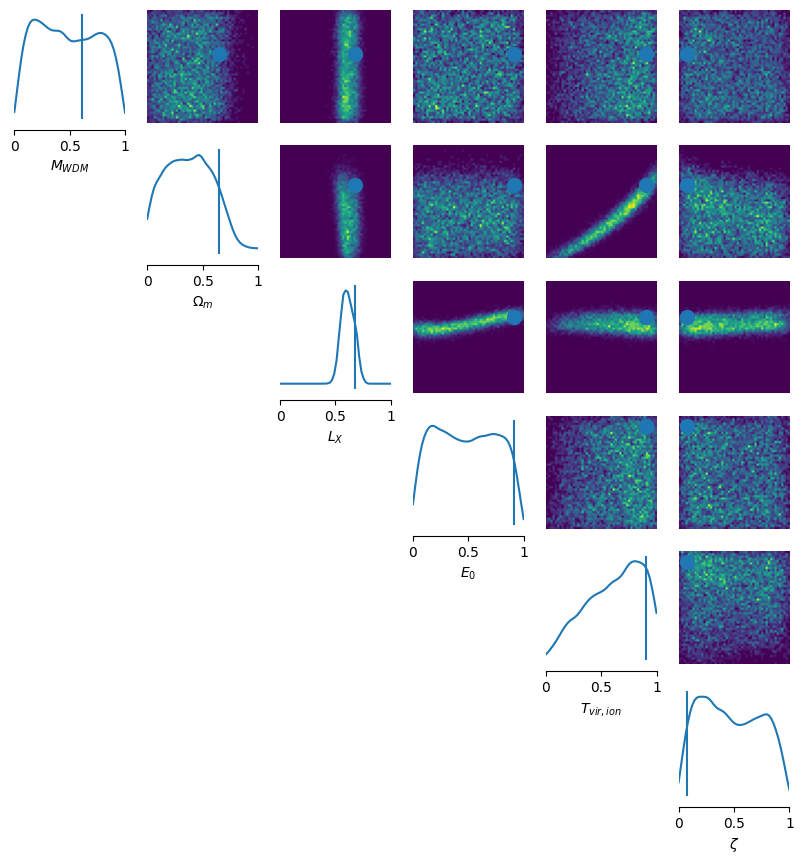

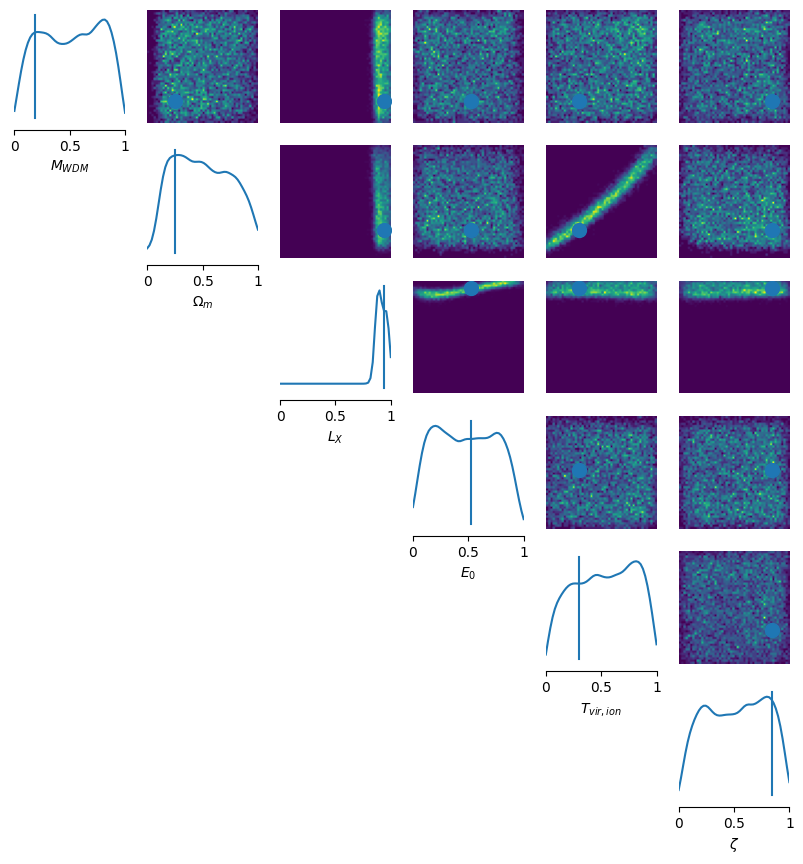

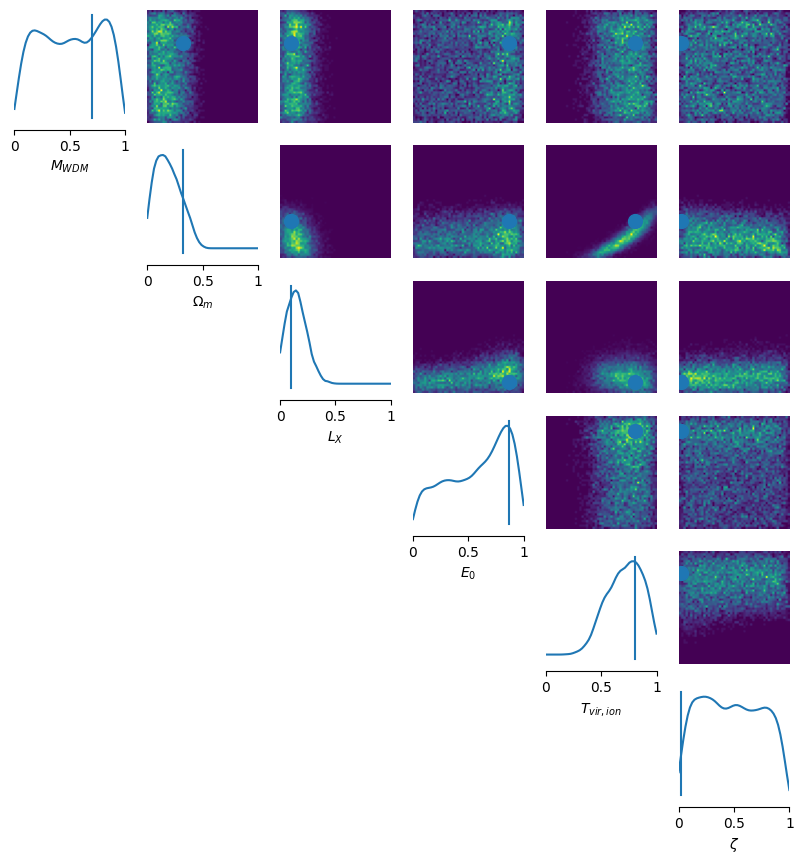

<Figure size 800x600 with 0 Axes>

In [11]:
import seaborn as sns
ana = Analysis(sbi, test_dataloader, device)
ana.marginals()
labels,prior_samples,_ = ana.sampler(num_samples=200, sumnet=True)

z, _ = ana.trainer.de_net(labels.to(ana.device), prior_samples.to(ana.device))
z = z.detach().cpu().numpy()

plt.figure(figsize=(8, 6))
sns.hist(z, xticklabels=ana.labels, hue="Parameters", y="Counts")
plt.title("Marginal Pearson correlation coefficients")
if self.save:
    plt.savefig(ana.path + ana.filename + "_latent_space.png", dpi=320)
else:
    plt.show()

<Axes: ylabel='Count'>

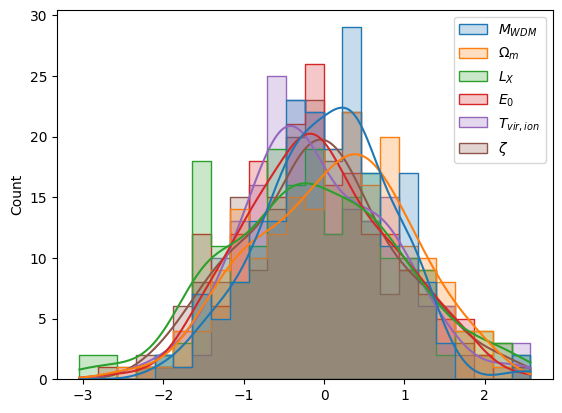

In [12]:
int(1.5)

1

In [ ]:
# opti search

from hyperopt import hp
search_space = {
                #"uniform": tune.uniform(-5, -1),  # Uniform float between -5 and -1
                #"quniform": tune.quniform(3.2, 5.4, 0.2),  # Round to multiples of 0.2
                #"loguniform": tune.loguniform(1e-4, 1e-1),  # Uniform float in log space
                #"qloguniform": tune.qloguniform(1e-4, 1e-1, 5e-5),  # Round to multiples of 0.00005
                #"randn": tune.randn(10, 2),  # Normal distribution with mean 10 and sd 2
                #"qrandn": tune.qrandn(10, 2, 0.2),  # Round to multiples of 0.2
                #"randint": tune.randint(-9, 15),  # Random integer between -9 and 15
                #"qrandint": tune.qrandint(-21, 12, 3),  # Round to multiples of 3 (includes 12)
                #"lograndint": tune.lograndint(1, 10),  # Random integer in log space
                #"qlograndint": tune.qlograndint(1, 10, 2),  # Round to multiples of 2
                #"choice": tune.choice(["a", "b", "c"]),  # Choose one of these options uniformly
                "optimizer": tune.choice([torch.optim.AdamW]),
                "optimizer_kwargs" : {
                    "lr" : tune.loguniform(1e-5, 1e-1),
                    "weight_decay" : tune.loguniform(1e-5, 1e-1),
                },
                "summary_network_kwargs" : {
                "layer_per_block1": tune.randint(1, 3),
                "layersize1" : tune.randint(2, 128),
                "filter_size1" : tune.choice([2, 3, 5, 7]),
                
                "layer_per_block2": tune.randint(1, 3),
                "layersize2" : tune.randint(2, 128),
                "filter_size2" : tune.choice([2, 3, 5, 7]),
                
                "layer_per_block3": tune.randint(1, 3),
                "layersize3" : tune.randint(2, 128),
                "filter_size3" : tune.choice([2, 3, 5, 7]),},
                    
}

train_kwargs = {"epochs": 200,
                "training_data": train_dataloader,
                "test_data": test_dataloader,}

model_sn = SNHandler(Summary_net_1dps, device = 'cuda', no_progress_bar=True)
model_sn.opti_params(search_space=search_space, 
                train_kwargs=train_kwargs)

2024-11-26 10:51:55,055	WARNING hyperopt_search.py:193 -- You passed a `space` parameter to <class 'ray.tune.search.hyperopt.hyperopt_search.HyperOptSearch'> that contained unresolved search space definitions. <class 'ray.tune.search.hyperopt.hyperopt_search.HyperOptSearch'> should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `param_space` argument to `tune.Tuner()` instead.
2024-11-26 10:51:56,691	INFO worker.py:1816 -- Started a local Ray instance.
2024-11-26 10:51:57,198	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-11-26 10:51:57,199	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


/home/allomere/Documents/projects/master/ml-venv/lib/python3.12/site-packages/hyperopt/utils.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


Trial name,loss
training_0ed444da,0.08151765838265419
training_1407ea98,0.08514683321118355
training_21c59253,0.03579171076416969
training_2a8408da,0.08618506640195847
training_8369aa53,
training_8bdb4eec,0.022731196880340577
training_9289cb77,0.08440025821328163
training_bb6f61af,0.0810350388288498
training_ea626acd,0.03818290196359157
training_fad072d2,0.05045669488608837


(training pid=61648) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/allomere/ray_results/training_2024-11-26_10-51-57/training_21c59253_1_optimizer=class_torch_optim_adamw_AdamW,lr=0.0001,weight_decay=0.0011,filter_size1=2,filter_size2=5,filter_siz_2024-11-26_10-51-57/checkpoint_000000)
(training pid=61648) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/allomere/ray_results/training_2024-11-26_10-51-57/training_21c59253_1_optimizer=class_torch_optim_adamw_AdamW,lr=0.0001,weight_decay=0.0011,filter_size1=2,filter_size2=5,filter_siz_2024-11-26_10-51-57/checkpoint_000001)
(training pid=61648) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/allomere/ray_results/training_2024-11-26_10-51-57/training_21c59253_1_optimizer=class_torch_optim_adamw_AdamW,lr=0.0001,weight_decay=0.0011,filter_size1=2,filter_size2=5,filter_siz_2024-11-26_10-51-57/checkpoint_000002)
(training pid=61648) Checkpoint successfully crea

In [2]:
import torch
torch.rand(32,10,8)*torch.rand(32,10,1)

tensor([[[1.7331e-01, 9.7558e-02, 3.1461e-02,  ..., 1.8343e-02,
          3.3740e-02, 1.7062e-01],
         [6.3717e-02, 9.6667e-02, 6.0314e-02,  ..., 9.1112e-03,
          2.7042e-02, 2.6892e-02],
         [1.3216e-01, 3.5626e-02, 1.2157e-01,  ..., 1.4855e-01,
          1.4144e-01, 1.2525e-01],
         ...,
         [2.6924e-01, 9.3517e-01, 9.3411e-01,  ..., 9.9032e-01,
          5.4674e-01, 6.2839e-01],
         [5.9190e-01, 5.8615e-01, 2.3512e-02,  ..., 2.2805e-01,
          3.5404e-01, 1.7088e-01],
         [4.7252e-02, 3.4985e-02, 7.7281e-02,  ..., 1.4227e-01,
          4.4623e-01, 3.1859e-01]],

        [[4.1053e-01, 5.2179e-01, 2.7377e-02,  ..., 5.1352e-01,
          3.0144e-01, 4.1003e-01],
         [1.4757e-01, 2.1700e-01, 7.6321e-02,  ..., 3.4352e-02,
          4.3427e-02, 3.2627e-01],
         [8.9549e-02, 1.2529e-01, 4.2329e-02,  ..., 4.1626e-03,
          7.3118e-02, 9.6124e-02],
         ...,
         [8.4274e-02, 1.4743e-01, 7.8406e-02,  ..., 1.4699e-01,
          2.403

In [6]:
ana = Analysis(sbi, test_dataloader, device)

In [10]:
sbi.de_net.sample(10, torch.rand(1,6).to(device))

tensor([[ 0.4187,  0.2971, -0.0057,  0.7934,  0.5480,  0.6824],
        [ 0.5135,  0.7930,  0.5036,  0.0430,  0.1733,  0.0874],
        [ 0.4817,  0.6972,  0.0073,  0.5653,  0.4492,  0.6618],
        [ 0.8672,  0.7444,  0.4407,  0.2979,  0.0344,  0.4490],
        [ 0.1471,  0.5097,  0.0688,  0.3984,  0.2734,  0.8260],
        [ 0.2197,  0.7097,  0.2352,  0.2366,  0.2690,  0.6878],
        [ 0.5137,  0.6963,  0.3141,  0.1047,  0.3393,  0.5778],
        [ 0.5077,  0.6879,  0.2412,  0.1005,  0.1597,  0.1835],
        [ 0.2751,  0.8039,  0.3129,  0.2502,  0.3711,  0.6648],
        [ 0.3087,  0.8086,  0.1041,  0.2935,  0.4739,  0.5721]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [8]:
#ana.marginals()
#ana.conditionals()
sbi.de_net._device = device
sbi.de_net.to(device)
ana.run_sbc()

|████████████████████████████████████████| 11/11 [100%] in 1.0s (10.80/s)       
{'kstest_pvals': tensor([0.0775, 0.5052, 0.0019, 0.0015, 0.1977, 0.0024])}


/home/allomere/Documents/projects/master/21cm-sbi/analysis.py:168: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/allomere/Documents/projects/master/21cm-sbi/analysis.py:218: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 3000x500 with 0 Axes>

<Figure size 3000x500 with 0 Axes>

{'sensitivity_sum_net_image': tensor([0.0035, 0.0018, 0.0011, 0.0011, 0.0015, 0.0016, 0.0013, 0.0005, 0.0001],
       device='cuda:0'), 'sensitivity_sum_net_range': tensor([0.0002, 0.0056], device='cuda:0')}
torch.Size([10, 6])
{'sensitivity_density_net_logprob': tensor([0.0952, 0.2920, 0.0810, 0.1007, 0.2179, 0.3954], device='cuda:0')}

In [ ]:
with torch.no_grad():
    for lab, img, rnge in test_dataloader:
        lab, img, rnge = lab.to(device), img.to(device), rnge.to(device)
        img = sbi.summary_net(img, rnge)
        for im in img:
            img = im.unsqueeze(0)
            samples = sbi.density_estimator.sample(1000, im)
        

In [ ]:
x, rnge = torch.rand(32,10,8).to(device), torch.rand(32,2).to(device)
rnge.requires_grad = True
x.requires_grad = True
out = sbi.summary_net(x, rnge).cpu().mean(0).mean()
out.backward()
print(rnge.grad.mean(0))
print(x.grad.mean(0).mean(0))

In [ ]:
idx = [-1]
data = torch.rand(32,10,8)
if axis == [-1]:
    axes_to_exclude = [data.dim() - 1]
axes_to_reduce = [i for i in range(data.dim()) if i not in idx]
print(torch.mean(data, dim=axes_to_reduce).shape)

In [ ]:
axes_to_reduce

In [ ]:
import torch

# Example input tensor with gradient tracking enabled
input_tensor = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)

# Define a simple model or function for demonstration
# Here we use a simple sum of squares as an example function
output = input_tensor.pow(2).sum()

# Perform backpropagation to calculate gradients
output.backward()

# The gradient (sensitivity) of the output with respect to the input
sensitivity = input_tensor.grad
print("Sensitivity:\n", sensitivity)

In [ ]:
def get_tarp_refpoint(thetas: Tensor) -> Tensor:
    """Returns reference points for the TARP diagnostic, sampled from a uniform."""

    # obtain min/max per dimension of theta
    lo = thetas.min(dim=0).values  # min for each theta dimension
    hi = thetas.max(dim=0).values  # max for each theta dimension

    refpdf = torch.distributions.Uniform(low=lo, high=hi)

    # sample one reference point for each entry in theta
    return refpdf.sample(torch.Size([thetas.shape[0]]))

num_points, num_samples = 32,500

# apply samplfunc with sumnet true here
for lab, img, rnge in test_dataloader:
    img, rnge = img.to(device), rnge.to(device)
    img = sbi.summary_net(img, rnge).detach().cpu()
    break
    
    
for i in range(num_points):
    sample = sbi.density_estimator.sample(num_samples=num_samples, x=img[i]).unsqueeze(1).detach().cpu()
    if i == 0:
        samples = sample
    else:
        samples = torch.cat([samples, sample], dim=1)
del img, rnge
        
num_bins = 30

if num_bins is None:
    num_bins = num_samples // 10

distance = torch.nn.MSELoss(reduction='none')

reference = get_tarp_refpoint(lab)

# distances between references and samples
sample_dists = distance(reference, samples)

# distances between references and true values
theta_dists = distance(reference, lab)

# compute coverage, f in algorithm 2
coverage_values = (
    torch.sum(sample_dists < theta_dists, dim=0) / num_samples
)
hist, alpha = torch.histogram(coverage_values, density=True, bins=num_bins)
# calculate empirical CDF via cumsum and normalize
ecp = torch.cumsum(hist, dim=0) / hist.sum()
# add 0 to the beginning of the ecp curve to match the alpha grid
ecp = torch.cat([Tensor([0]), ecp])

# Similar to SBC, we can check then check whether the distribution of ecp is close to
# that of alpha.
atc, ks_pval = check_tarp(ecp, alpha)
print(atc, "Should be close to 0")
print(ks_pval, "Should be larger than 0.05")

plot_tarp(ecp, alpha);

In [ ]:
import seaborn as sb
sb.heatmap(blub.detach(), cmap='coolwarm', vmin=-1, vmax=1)

In [ ]:
name = 'aug_'

# rewrite rev_sample, the current implementation is really shitty
sbi.run_sbc(Validation_Dataset = test_dataloader, plotname= name,)
'''sampling_parameter={
    'sample_with' :'mcmc',
    'num_chains': 20,
    "method": "slice_np_vectorized"})'''


#noaug: tensor([8.7545e-05, 2.1467e-05, 1.9525e-05, 4.4741e-15, 5.4385e-06, 5.0802e-11])
# aug: tensor([9.5508e-09, 1.0710e-13, 4.7865e-04, 1.3318e-08, 8.7801e-09, 5.4540e-06])


In [ ]:
len(test_dataloader)

In [ ]:
import torch.distributions.transforms as torch_tf
from torch.optim.adam import Adam

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)
potential_fn = LikelihoodBasedPotential(sbi.density_estimator, prior, x_o=torch.rand(6, device=device), device=device)
loss = potential_fn(torch.rand(6,6, device=device)).squeeze().sum()




potential_fn = potential_fn
inits = prior.sample((100,))
theta_transform = None
num_iter = 1_000
num_to_optimize = 5
learning_rate = 0.01
save_best_every = 10
show_progress_bars = False
interruption_note = ""

if theta_transform is None:
    theta_transform = torch_tf.IndependentTransform(
        torch_tf.identity_transform, reinterpreted_batch_ndims=1
    )
else:
    theta_transform = theta_transform

init_probs = potential_fn(inits).detach()

# Pick the `num_to_optimize` best init locations.
sort_indices = torch.argsort(init_probs, dim=0)
sorted_inits = inits[sort_indices]
optimize_inits = sorted_inits[-num_to_optimize:]

# The `_overall` variables store data accross the iterations, whereas the
# `_iter` variables contain data exclusively extracted from the current
# iteration.
best_log_prob_iter = torch.max(init_probs)
best_theta_iter = sorted_inits[-1]
best_theta_overall = best_theta_iter.detach().clone()
best_log_prob_overall = best_log_prob_iter.detach().clone()

argmax_ = best_theta_overall
max_val = best_log_prob_overall

optimize_inits = theta_transform(optimize_inits)
optimize_inits.requires_grad_(True)  # type: ignore
optimizer = Adam([optimize_inits], lr=learning_rate)  # type: ignore

iter_ = 0

# Try-except block in case the user interrupts the program and wants to fall
# back on the last saved `.map_`. We want to avoid a long error-message here.

while iter_ < num_iter:
    optimizer.zero_grad()
    probs = potential_fn(theta_transform.inv(optimize_inits)).squeeze()
    print(optimize_inits)
    print(probs)
    loss = probs.sum()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        if iter_ % save_best_every == 0 or iter_ == num_iter - 1:
            # Evaluate the optimized locations and pick the best one.
            log_probs_of_optimized = potential_fn(
                theta_transform.inv(optimize_inits)
            )
            best_theta_iter = optimize_inits[  # type: ignore
                torch.argmax(log_probs_of_optimized)
            ].view(1, -1)
            best_log_prob_iter = potential_fn(
                theta_transform.inv(best_theta_iter)
            )
            if best_log_prob_iter > best_log_prob_overall:
                best_theta_overall = best_theta_iter.detach().clone()
                best_log_prob_overall = best_log_prob_iter.detach().clone()

        if show_progress_bars:
            print(
                "\r",
                f"Optimizing MAP estimate. Iterations: {iter_ + 1} / "
                f"{num_iter}. Performance in iteration "
                f"{divmod(iter_ + 1, save_best_every)[0] * save_best_every}: "
                f"{best_log_prob_iter.item():.2f} (= unnormalized log-prob)",
                end="",
            )
        argmax_ = theta_transform.inv(best_theta_overall)
        max_val = best_log_prob_overall

    iter_ += 1

In [ ]:
sample_attr = {
        "sample_with": "mcmc", 
        "mcmc_method": "slice_np_vectorized",
        "warmup_steps": 200,
        "num_chains": 16, # change 
        "init_strategy": "proposal", # try 'sir' here
        "num_workers": 4,
}
print(type(sample_attr))
blub = sample_attr.pop('sample_with')
print(blub)

In [ ]:
# sbi
with torch.no_grad():
    for i, (lab, img,_) in enumerate(test_dataloader):
        img, lab = img.to(device), lab.to(device)
        
        if not i:
            summary_vec = torch.empty(0,lab.shape[1], device=device)
            labels = torch.empty(0,lab.shape[1], device=device)

        pred = sbi.summary_net(img)
        summary_vec = torch.cat((summary_vec, pred), dim=0)
        labels = torch.cat((labels, lab), dim=0)

num_samples = 10000
rank_inn = torch.empty(summary_vec.shape)
dap_samples = torch.empty((summary_vec.shape[0], summary_vec.shape[1]))
# sbc rank stat
with alive_bar(summary_vec.shape[0], force_tty=True, refresh_secs=1) as bar:
    for i in range(summary_vec.shape[0]):
        samples = sbi.density_estimator.sample(x = summary_vec[i].unsqueeze(0), num_samples=num_samples,
                                                 enable_transform=False,
                                           sample_with='mcmc', mcmc_method="slice_np_vectorized")
        samples = samples.detach()
        dap_samples[i] = samples[0]
        for j in range(summary_vec.shape[1]):
            rank_inn[i,j] = (samples[:,j]<labels[i,j]).sum().item()
        bar()
        
'''rank_maf = torch.empty(summary_vec.shape)
# sbc rank stat
with alive_bar(summary_vec.shape[0], force_tty=True, refresh_secs=1) as bar:
    for i in range(summary_vec.shape[0]):
        samples = posterior.posterior_estimator.sample((10000,), summary_vec[i].unsqueeze(0))[:,0,:]
        samples = samples.detach()
        dap_samples[i] = samples[0]
        for j in range(summary_vec.shape[1]):
            rank_maf[i,j] = (samples[:,j]<labels[i,j]).sum().item()
        bar()'''


In [ ]:

with torch.no_grad():
    for i, (lab, img,_) in enumerate(test_dataloader):
        img, lab = img.to(device), lab.to(device)
        
        if not i:
            summary_vec = torch.empty(0,lab.shape[1], device=device)
            labels = torch.empty(0,lab.shape[1], device=device)

        pred = sbi.summary_net(img)
        summary_vec = torch.cat((summary_vec, pred), dim=0)
        labels = torch.cat((labels, lab), dim=0)

num_samples = 10000
rank_inn = torch.empty(summary_vec.shape)
dap_samples = torch.empty((summary_vec.shape[0], summary_vec.shape[1]))
# sbc rank stat
with alive_bar(summary_vec.shape[0], force_tty=True, refresh_secs=1) as bar:
    for i in range(summary_vec.shape[0]):
        samples = sbi.density_estimator.sample(x = summary_vec[i].unsqueeze(0), num_samples=num_samples,
                                                 enable_transform=False,
                                           sample_with='mcmc', mcmc_method="slice_np_vectorized")
        samples = samples.detach()
        dap_samples[i] = samples[0]
        for j in range(summary_vec.shape[1]):
            rank_inn[i,j] = (samples[:,j]<labels[i,j]).sum().item()
        bar()
        
'''rank_maf = torch.empty(summary_vec.shape)
# sbc rank stat
with alive_bar(summary_vec.shape[0], force_tty=True, refresh_secs=1) as bar:
    for i in range(summary_vec.shape[0]):
        samples = posterior.posterior_estimator.sample((10000,), summary_vec[i].unsqueeze(0))[:,0,:]
        samples = samples.detach()
        dap_samples[i] = samples[0]
        for j in range(summary_vec.shape[1]):
            rank_maf[i,j] = (samples[:,j]<labels[i,j]).sum().item()
        bar()'''


In [ ]:
plt.hist(samples[:,0].detach().cpu(), range=(-5,5), bins=20)

In [ ]:
for i in range(3):
    lab, img, _ = test_dataloader.dataset[i+2]

    lab, img = lab.to(device), img.to(device)
    img = img.unsqueeze(0)

    summary = sbi.summary_net(img).detach()
    cond_size = summary.shape[-1]
    summaryn = summary.repeat(5,1)
    labn = torch.cat([lab.unsqueeze(0), torch.rand(4,6, device=device)], dim=0)
    log_prob = sbi.density_estimator.log_prob(summaryn, labn)
    print(- (logp.sum(-1) + sbi.density_estimator.base_dist.log_prob(samples).sum(-1)))
    print(log_prob.shape)
    print(lab)
    print(density_net.log_prob(summaryn.unsqueeze(0),labn).shape)
    break
utils.BoxUniform(low=torch.zeros(6), high=torch.ones(6), device=device).log_prob(samples)

In [ ]:
samples[0].shape

In [ ]:
print(-density_net.log_prob(labn.unsqueeze(0), summaryn))
s, p = sbi.density_estimator.forward(summaryn, labn)
p = p.sum(-1) + sbi.density_estimator.base_dist.log_prob(s).sum(-1)
print(-p)

In [ ]:
summaryn = summary.squeeze(0)
labn = labn
print(summaryn.shape, labn.shape)
density_net.log_prob(labn, summaryn)

In [ ]:
device = 'cuda'
sbi.density_estimator.net.to(device)
sbi.device = device
prior = utils.BoxUniform(low=torch.zeros(6), high=torch.ones(6), device=device)
potential_fn = LikelihoodBasedPotential(sbi.density_estimator, prior, x_o=None, device=device)

In [ ]:
potential_fn.set_x(torch.rand(1,6, device=device))
print(potential_fn(torch.rand(10,6, device=device)))

posterior = MCMCPosterior(
    potential_fn=potential_fn, proposal=prior
)

In [ ]:
utils.BoxUniform(low=torch.zeros(6), high=torch.ones(6), device=device).log_prob(torch.rand(10,6, device='cuda')).shape

In [ ]:
for lab, x, _ in test_dataloader:
    break

batch_size=1
batch_size_prior = 32
x = sbi.summary_net.to('cpu')(x)[0].unsqueeze(0)
sbi.density_estimator.to('cpu')
sbi.device = 'cpu'
theta_prior = torch.rand(32, 6)
repeated_x =  repeat_rows(x, 11)
lab = lab[0].unsqueeze(0)
probs = torch.cat(
        [(1 - torch.eye(batch_size)), torch.ones(batch_size, batch_size_prior)], dim=-1
        ) / (batch_size + batch_size_prior - 1)
choices = torch.multinomial(probs, num_samples=10, replacement=False)

contrasting_theta = torch.cat([lab, theta_prior], dim=0)[choices]
atomic_theta = torch.cat((lab[:, None, :], contrasting_theta), dim=1).reshape(
    batch_size * (11), -1
)
res = sbi.density_estimator.forward(atomic_theta, repeated_x).reshape(
            batch_size, 10 + 1
        )

In [ ]:
from torch import distributions as D
D.Uniform(0,1).sample((10,))

In [ ]:
torch.distributions.Uniform(0,1).sample((10,))

In [ ]:
sbi.density_estimator.base_dist.sample((10000,))

In [ ]:
plt.hist2d?

In [ ]:
'''prior = (lambda x: x)
sbi = SBIHandler(density_estimator=model_de, summary_net=model_sn.Model, device=device)
sbi.load_model()'''

lab, img, _ = test_dataloader.dataset[3]

lab, img = lab.to(device), img.to(device)
img = img.unsqueeze(0)

summary = sbi.summary_net(img)

samples, _ = sbi.density_estimator.sample(10000, summary)
print(samples.shape)
# plot posterior samples
figure, axis = analysis.pairplot(samples = samples.detach().to('cpu').numpy(), points=lab.detach().to('cpu').numpy(),
       limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
       labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
       #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
       upper = 'hist', lower = 'contour', diag = 'kde')
figure.savefig("inn_40.png", dpi=300)
figure.show()

In [ ]:
plt.hist(posterior.posterior_estimator.sample((1000,), summary_vec[0].unsqueeze(0))[:,0,0].detach().cpu().numpy(), bins=50)
plt.show()

In [ ]:
### SNPE ###

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNPE
from sbi import utils, analysis
from sbi.utils import RestrictedPrior, get_density_thresholder

# load the summary model
model = SumnetHandler(Model = Summary_net_lc_super_smol, device=device)
model.load("./summary_net.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=128, num_transforms=6, z_score_theta='none',
    z_score_x='none', batch_norm=True
)

# train the maf
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun, device=device)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]


density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=99,
                                    stop_after_epochs=99,
                                    max_num_epochs=20,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)


for i in range(3):
    lab, img, _ = test_dataloader.dataset[i]

    lab, img = lab.to(device), img.to(device)
    img = img.unsqueeze(0)

    summary = sbi.summary_net(img).detach()
    cond_size = summary.shape[-1]
    nsamples = 1000
    samples = posterior.sample(nsamples, summary)
    # plot posterior samples
    figure, axis = analysis.pairplot(samples = samples.detach().to('cpu').numpy(), points=lab.detach().to('cpu').numpy(),
        limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
        labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
        #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
        upper = 'hist', lower = 'contour', diag = 'kde')
    if save: figure.savefig(f"maf_theirs_{i}.png", dpi=300)
    figure.show()


In [ ]:
for i in range(3):
    lab, img, _ = test_dataloader.dataset[i]

    lab, img = lab.to(device), img.to(device)
    img = img.unsqueeze(0)

    summary = sbi.summary_net(img).detach()
    cond_size = summary.shape[-1]
    nsamples = 1000
    samples = posterior.sample((nsamples,), summary)
    # plot posterior samples
    figure, axis = analysis.pairplot(samples = samples.detach().to('cpu').numpy(), points=lab.detach().to('cpu').numpy(),
        limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
        labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
        #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
        upper = 'hist', lower = 'contour', diag = 'kde')
    if save: figure.savefig(f"maf_theirs_{i}.png", dpi=300)
    figure.show()

In [ ]:
### SNPE - backup ###

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# load the summary model
model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("./summary_net.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6, z_score_theta='none',
    z_score_x='none', 
)

# train the maf
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun, device=device)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]


density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=5,
                                    stop_after_epochs=20,
                                    max_num_epochs=20,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    #fig.savefig(f"./NPE_{i}.png", dpi=300)

In [ ]:
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )

In [ ]:
for i in range(10):
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)

    x = x.to(device)

    x = model.Model(x).detach()
    sample, prob = density_net.sample_and_log_prob(sample_shape=torch.tensor([1]), condition=x.to('cuda'))
    print("summary-vec = ", x)
    print("true-vec = ", y)
    print("sample-vec = ", sample.detach())
    print("prob = ", prob.item())
    print()
    

In [ ]:
?

In [ ]:
torch.unsqueeze(train_dataloader.dataset.__getitem__(0)[1],0).shape

In [ ]:
with open("delete.me", "wb") as handle:
    pickle.dump(density_net, handle)

In [ ]:
train_loss_summary_net, train_loss_density_net, test_loss_summary_net, test_loss_density_net = statistics
plt.plot(train_loss_summary_net, label=r'$\log \mathcal{L}_{\Phi_{train}}$')
plt.plot(np.asarray(train_loss_density_net)/32, label=r'$\log \mathcal{L}_{\varphi_{train}}$')   
plt.plot(test_loss_summary_net, label=r'$\log \mathcal{L}_{\Phi_{test}}$')
plt.plot(np.asarray(test_loss_density_net)/32, label=r'$\log \mathcal{L}_{\varphi_{test}}$')
plt.vlines(9, 0.5, 0, color='b', label='joint learning', colors='black')
plt.legend()
#plt.savefig("NPE_nsf_joint_loss.png", dpi=400)
plt.show()


In [ ]:
### NRE ###



from sbi.utils.get_nn_models import (
    likelihood_nn
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNLE
from sbi import utils, analysis

# load the summary model
model = SumnetHandler(Model = Summary_net_lc_super_smol, device=device)
model.load("./summary_net.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
ratio_estimator = (lambda x,y: NSF_AR(in_dim=6, n_blocks=2, n_nodes=64, reversed=True,
               hidden_layer=1, batch_norm=True, device=device))

ratio_estimator = likelihood_nn(
    model = 'nsf', z_score_x='none',  z_score_theta='none', 
    hidden_features=64, num_blocks=3, use_batch_norm=True
)



# train the maf
inference = SNLE(prior=prior, device=device, density_estimator=ratio_estimator)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]

density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=50,
                                    stop_after_epochs=20,
                                    max_num_epochs=0,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((1000,), x=x, num_chains=5, mcmc_method='slice_np_vectorized').to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    fig.savefig(f"./NRE_{i}.png", dpi=300)

In [ ]:
from sbi.inference.potentials.likelihood_based_potential import likelihood_estimator_based_potential

In [ ]:
pot = LikelihoodBasedPotential(density_net, prior=prior, x_o=None, device='cuda')

In [ ]:
pot.set_x(torch.rand(1,6, device='cuda'))
pot(torch.rand(10,6,device='cuda'))

In [ ]:
from sbi.inference import SNRE_C as SNRE
ratio_estimator = (lambda x,y: ResNet(in_dim=6, n_blocks=2, n_nodes=64,
               hidden_layer=2, batch_norm=True, device=device))

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

'''ratio_estimator = classifier_nn(
    model = 'resnet', z_score_x='none',  z_score_theta='none', 
    hidden_features=64, num_blocks=2, use_batch_norm=True
)'''

# train the maf
inference = SNLE(prior=prior, device=device, density_estimator=ratio_estimator)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((1000,), x=x, num_chains=20, mcmc_method='slice_np_vectorized').to('cpu')

    # plot posterior samples
    figure, axis = pairplot(samples = posterior_samples.cpu().numpy(), points=y.cpu().numpy(),
        limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
        labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
        #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
        upper = 'hist', lower = 'contour', diag = 'kde')
    if save: figure.savefig(f"nre_{i}_old.png", dpi=300)
    figure.show()
    
    fig.savefig(f"./NRE_{i}.png", dpi=300)

In [ ]:
plt.plot(np.asarray(statistics)[1])
plt.plot(np.asarray(statistics)[3])

In [ ]:
from sbi.diagnostics import check_sbc, run_sbc
from sbi.analysis import sbc_rank_plot

In [ ]:
from sbi.utils.torchutils import repeat_rows
from torch import eye, ones
num_atoms=10

y,x,_ = test_dataloader.dataset.__getitem__(0)
y,x = y.unsqueeze(0), x.unsqueeze(0)
print(y.shape, x.shape)
x = model.Model(x)

y1, x1,_ = test_dataloader.dataset.__getitem__(1)
y1,x1 = y1.unsqueeze(0), x1.unsqueeze(0)
x1 = model.Model(x1)

y, x = torch.cat((y,y1)), torch.cat((x,x1))

batch_size = y.shape[0]
print(f'{batch_size=}')

repeated_x = repeat_rows(x, num_atoms)
print(f'{repeated_x=}')

# Choose `1` or `num_atoms - 1` thetas from the rest of the batch for each x.
probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)
print(f'{probs=}')

choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)

In [ ]:

# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))

In [ ]:
# take closer look at test
ModelHandler.test_specific(test_dataloader, model.Model, loss(**loss_params), 1, denormalize=test_data.denormalize)

# save the model
#model.save_model(name = "summary_net.pt")

In [ ]:
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# define model hyperparemeter
user_params = {
"HII_DIM": 40,
"BOX_LEN": 160,
"N_THREADS": 2,
"USE_INTERPOLATION_TABLES": True,
"PERTURB_ON_HIGH_RES": True
}

flag_options = {
"INHOMO_RECO": True,
"USE_TS_FLUCT": True
}

#simparams = p21c.outputs.LightCone.read("./data/run_36690")
# load the simulator class
Leaf_simulator = Leaf(debug=True, user_params=user_params, flag_options=flag_options, redshift = 5.5)

# define the prior ranges (only need for denormalization!)
prior_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)

# define the prior (uniform prior in this case)
prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)))


'''# define the simulator
def simulation(theta):
    M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR = theta
    cosmo_params = {
        "OMm": OMm.item()
        }
    astro_params = {
        "L_X": L_X.item(),
        "NU_X_THRESH": NU_X_THRESH.item(),
        "ION_Tvir_MIN": ION_Tvir_MIN.item(),
        "HII_EFF_FACTOR": HII_EFF_FACTOR.item(),
        "INHOMO_RECO": True
    }
    global_params = {
        "M_WDM": M_WDM.item()
    }


    return Model.fast_forward(torch.as_tensor(Leaf_simulator.run_lightcone(
        save = False, sanity_check = True, filter_peculiar = False, debug=False,
        astro_params = astro_params, global_params = global_params, cosmo_params = cosmo_params).brightness_temp, dtype=torch.float32))


def simulator(theta: torch.FloatTensor, Model: object, threads: int = 1):
    tshape = theta.shape
    schwimmhalle = Pool(max_workers=threads, max_tasks_per_child=1, mp_context=get_context('spawn'))
    runner = [params for params in theta]
    result = []
    with alive_bar(len(runner), force_tty=True) as bar: 
        with schwimmhalle as p:
            data = p.map(simulation, runner)
            for dat in data:
                lc_bt = future.result()

                dat.add_done_callback(bar())
    return data
'''

In [ ]:
# check if simulator is working
#prepare_for_sbi(prior = prior, simulator = simulation)

In [ ]:
# define point of interest
# [M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR]
x_o = torch.tensor([2, 0.30964144154550644, 40.0, 500.0, 4.69897, 30.0], dtype=torch.float32)

# A PPC is performed after we trained or neural posterior
posterior.set_default_x(x_o)

# We draw theta samples from the posterior. This part is not in the scope of SBI
if __name__ == '__main__':
    posterior_samples = posterior.sample((5000,))

# We use posterior theta samples to generate x data
    x_pp = torch.as_tensor(simulator(theta = posterior_samples, Model = model, threads=6))

# We verify if the observed data falls within the support of the generated data
_ = analysis.pairplot(
    samples=x_pp,
    points=x_o
)

In [ ]:
### SNLE ###

from sbi.utils.get_nn_models import (
    likelihood_nn,
)  

# load the summary model
model = ModelHandler(Model = Summary_net_lc_smol, device='cpu')
model.load_model("./summary_net.pt")

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6
)

# do inference using a freezed summary model
x,y = model.full_inference(train_dataloader)

# train the maf
inference = SNLE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(y,x)
density_estimator = inference.train()
# infere test data
x,y = model.full_inference(test_dataloader)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_estimator, prior=prior)
for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    posterior_samples = posterior.sample((10000,), x=x[idx,:], num_workers=10, method="slice_np_vectorized", num_chains=10)

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y[idx]

    )
    
    fig.savefig(f"./NLE_{i}.png", dpi=300)

In [ ]:
train_data = DataHandler(path="./data/", prefix="batch", load_to_ram=False,
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=.5)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)

In [ ]:
for dat in train_dataloader:
    img, _,_ = dat
    print(img.shape)
    plt.imshow(img[0,0,:,:,0])
    break

In [ ]:
data = torch.rand((100,100,100))
%timeit noise1(data)

In [ ]:
test = 0 if 0 == 1 elif

In [ ]:
from sbi import utils, analysis

from sbi.diagnostics import check_sbc, run_sbc
from sbi.analysis import sbc_rank_plot
import corner
import numpy as np
import arviz
import pickle
from sbi.inference.posteriors import MCMCPosterior

In [ ]:
with open("../NRE_de.pkl", "rb") as handle:
    posterior = pickle.load(handle)

posterior.potential_fn.device = 'cpu'
posterior = MCMCPosterior(potential_fn=posterior.potential_fn,
                          proposal=posterior.proposal,
                          theta_transform=posterior.theta_transform,
                          method='slice_np_vectorized',
                          thin=posterior.thin,
                          warmup_steps=posterior.warmup_steps,
                          num_chains=6,
                          num_workers=6,
                          device='cpu')

model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("../NRE_sn.pt")
sum_net = model.Model

with torch.no_grad():
    with alive_bar(len(test_dataloader), force_tty=True, refresh_secs=1) as bar:
        for i, (lab, img,_) in enumerate(test_dataloader):
            img, lab = img.to(device), lab.to(device)
            
            if not i:
                summary_vec = torch.empty(0,lab.shape[1], device=device)
                labels = torch.empty(0,lab.shape[1], device=device)

            pred = sum_net(img)
            summary_vec = torch.cat((summary_vec, pred), dim=0)
            labels = torch.cat((labels, lab), dim=0)
            bar()

xs = summary_vec
thetas = labels
num_sbc_runs = xs.shape[0]
num_posterior_samples = num_sbc_runs

#xs, thetas = model.full_inference(sbc_dataloader)

ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)

check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

fig, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
    parameter_labels = [r"$M_\text{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_\text{vir, ion}$", r"$\zeta$"],
)

fig.savefig("NRE_sbc_rank_maf_freezed_sum.png", dpi=300)

fig, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf", parameter_labels=[r"$M_\text{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_\text{vir, ion}$", r"$\zeta$"],)
fig.savefig("NRE_sbc_CDF_maf_freezed_sum.png", dpi=300)

In [ ]:
posterior.potential_fn

In [ ]:
for x,y,_ in train_dataloader:
    print(x.shape, y.shape)
    breal

In [ ]:
from torch.utils.data import TensorDataset
data_x, data_y = torch.zeros(100,1,28, 28, 470), torch.zeros(100,6)
dummy_idx = torch.zeros(100)

for i in range(100):
    if torch.rand(1).item()<0.5:
        data_x[i] = torch.ones(1,28, 28, 470)
        data_y[i] = torch.ones(6)


batch_size = 16
epochs = 5
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 1e-3,
}

loss = torch.nn.MSELoss
loss_params = {}

dataset_train = TensorDataset(data_y[:80], data_x[:80], dummy_idx[:80])
dataset_test = TensorDataset(data_y[80:], data_x[80:], dummy_idx[80:])

dataset_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


model = ModelHandler(Model = Summary_net_lc_super_smol,
                     Training_data=dataset_train, Test_data=dataset_test, device=device)


# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
#model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))